## Предсказание стоимости жилья

**Цель и задача:**
В проекте нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

**Описание данных** на входе 1 датасет `/datasets/housing.csv`.

`longitude` — широта;
`latitude` — долгота;
`housing_median_age` — медианный возраст жителей жилого массива;
`total_rooms` — общее количество комнат в домах жилого массива;
`total_bedrooms` — общее количество спален в домах жилого массива;
`population` — количество человек, которые проживают в жилом массиве;
`households` — количество домовладений в жилом массиве;
`median_income` — медианный доход жителей жилого массива;
`median_house_value` — медианная стоимость дома в жилом массиве;
`ocean_proximity` — близость к океану.

**План проекта**

1. [Подготовка данных](#1)
2. [Обучение модели](#2)
3. [Анализ результатов](#3)

In [1]:
import os

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.functions import col, sum as _sum
from functools import reduce

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
%matplotlib inline

# Подготовка данных <a id='1'></a>

Инициализируйте локальную Spark-сессию.

In [3]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Housing data in California in 1990") \
                    .getOrCreate()

Прочитайте содержимое файла /datasets/housing.csv.

In [4]:
pth1 = '/datasets/housing.csv'

    
    
if (os.path.exists(pth1)):
    df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True) 
else:
    print('Error Data path')

In [5]:
def info_df(data):
    display(data.printSchema())
    display(data.show())
    display(data.describe().toPandas())

In [6]:
info_df(df)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



None

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

None

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


В датасете 20640 записей. В колонке total_bedrooms	присутствуют пропуски. Стиилистика названий является допустимой. 9 столбцлов - количественный, `ocean_proximity` является единственным категориальным.

Посмотрю на наличие дубликатов и пропусков. Но для начала запишу количество записей в датасете.

In [7]:
num_rows = df.count()
print(f"Количество строк в DataFrame: {num_rows}")

Количество строк в DataFrame: 20640


In [8]:
def find_duplicates_info(data: DataFrame):
    
    duplicate_rows = data.dropDuplicates()

    num_duplicates = num_rows - duplicate_rows.count()
    percentage_duplicates = (num_duplicates / num_rows) * 100

    # Выводим результат
    print(f"Количество дубликатов в DataFrame: {num_duplicates}")
    print(f"Процент дубликатов от общего числа строк: {percentage_duplicates:.2f}%")

In [9]:
find_duplicates_info(df)

Количество дубликатов в DataFrame: 0
Процент дубликатов от общего числа строк: 0.00%


Явные дубликаты отсутствуют. Теперь посмотрю на пропуски.

In [10]:
def count_missing_values(data: DataFrame):
    # Считаем количество строк в DataFrame
    total_rows = data.count()
    
    # Считаем количество пропусков в каждом столбце
    missing_counts = data.select([_sum(col(column).isNull().cast("int")).alias(column) for column in data.columns]).collect()[0]
    
    # Выводим количество пропусков и процентное соотношение в каждом столбце
    for column, count in missing_counts.asDict().items():
        percentage = (count / total_rows) * 100
        print(f"Количество пропусков в столбце '{column}': {count} ({percentage:.2f}%)")

In [11]:
count_missing_values(df)

Количество пропусков в столбце 'longitude': 0 (0.00%)
Количество пропусков в столбце 'latitude': 0 (0.00%)
Количество пропусков в столбце 'housing_median_age': 0 (0.00%)
Количество пропусков в столбце 'total_rooms': 0 (0.00%)
Количество пропусков в столбце 'total_bedrooms': 207 (1.00%)
Количество пропусков в столбце 'population': 0 (0.00%)
Количество пропусков в столбце 'households': 0 (0.00%)
Количество пропусков в столбце 'median_income': 0 (0.00%)
Количество пропусков в столбце 'median_house_value': 0 (0.00%)
Количество пропусков в столбце 'ocean_proximity': 0 (0.00%)


Вижу, что в `total_bedrooms` присутствуют 207 пропусков, всего 1%. При этом количество строк в датасете 20640. Удалю строки с пропусками.

In [12]:
df = df.dropna()

Далее для количественных столбоцов построю гистограммы с боксплтами, для категориального - столбчатую диаграмму.

In [13]:
class DataVisualizer:
    def __init__(self, dataframe: DataFrame):
        self.dataframe = dataframe
        self.pandas_df = dataframe.toPandas()  # Преобразование DataFrame PySpark в Pandas DataFrame
        self.quantitative_columns = [col for col, dtype in dataframe.dtypes if dtype != 'string']
        self.categorical_columns = [col for col, dtype in dataframe.dtypes if dtype == 'string']

    def plot_quantitative(self):
        num_columns = len(self.quantitative_columns)
        rows = (num_columns + 2) // 3  # Определяем количество рядов, чтобы разместить по 3 графика в ряд
        fig, axs = plt.subplots(rows * 2, 3, figsize=(20, 5 * rows), gridspec_kw={'height_ratios': [0.5, 1.5] * rows})

        for i, column in enumerate(self.quantitative_columns):
            row = i // 3
            col = i % 3
            
            axs[row * 2, col].boxplot(self.pandas_df[column], vert=False)
            axs[row * 2, col].set_yticks([])
            axs[row * 2, col].set_xticks([])
        
            sns.histplot(self.pandas_df[column], ax=axs[row * 2 + 1, col], bins=15, kde=False, stat='density', common_norm=False)
            axs[row * 2 + 1, col].set_title(f'Гистограмма {column}')
            axs[row * 2 + 1, col].set_ylabel('Плотность')
        
        for j in range(num_columns, rows * 3):
            fig.delaxes(axs[(j // 3) * 2, j % 3])
            fig.delaxes(axs[(j // 3) * 2 + 1, j % 3])

        plt.tight_layout()
        fig.suptitle('Распределение количественных признаков', fontsize=16)
        plt.subplots_adjust(top=0.95)
        plt.show()

    def plot_categorical(self):
        for column in self.categorical_columns:
            plt.figure(figsize=(10, 7))
            sns.countplot(x=self.pandas_df[column])
            plt.title(f'Распределение категориального признака {column}')
            plt.xlabel(column)
            plt.ylabel('Количество')
        plt.show()

    def plot_correlation_heatmap(self):

        assembler = VectorAssembler(inputCols=self.quantitative_columns, outputCol="features")
        df_vectorized = assembler.transform(self.dataframe).select("features")
        
        corr_matrix = Correlation.corr(df_vectorized, "features").head()[0]
        corr_matrix = corr_matrix.toArray()

        corr_df = pd.DataFrame(corr_matrix, columns=self.quantitative_columns, index=self.quantitative_columns)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title('Тепловая карта корреляций числовых признаков')
        plt.show()

    def visualize(self):
        if self.quantitative_columns:
            self.plot_quantitative()
        if self.categorical_columns:
            self.plot_categorical()
        if self.quantitative_columns:
            self.plot_correlation_heatmap()

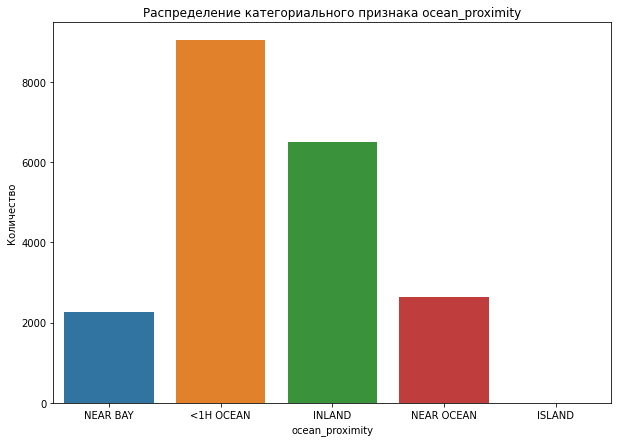

In [14]:
visualizer = DataVisualizer(df)
visualizer.plot_categorical()

Большинств жилья находится в пределах `<1H OCEAN`  и на материке.

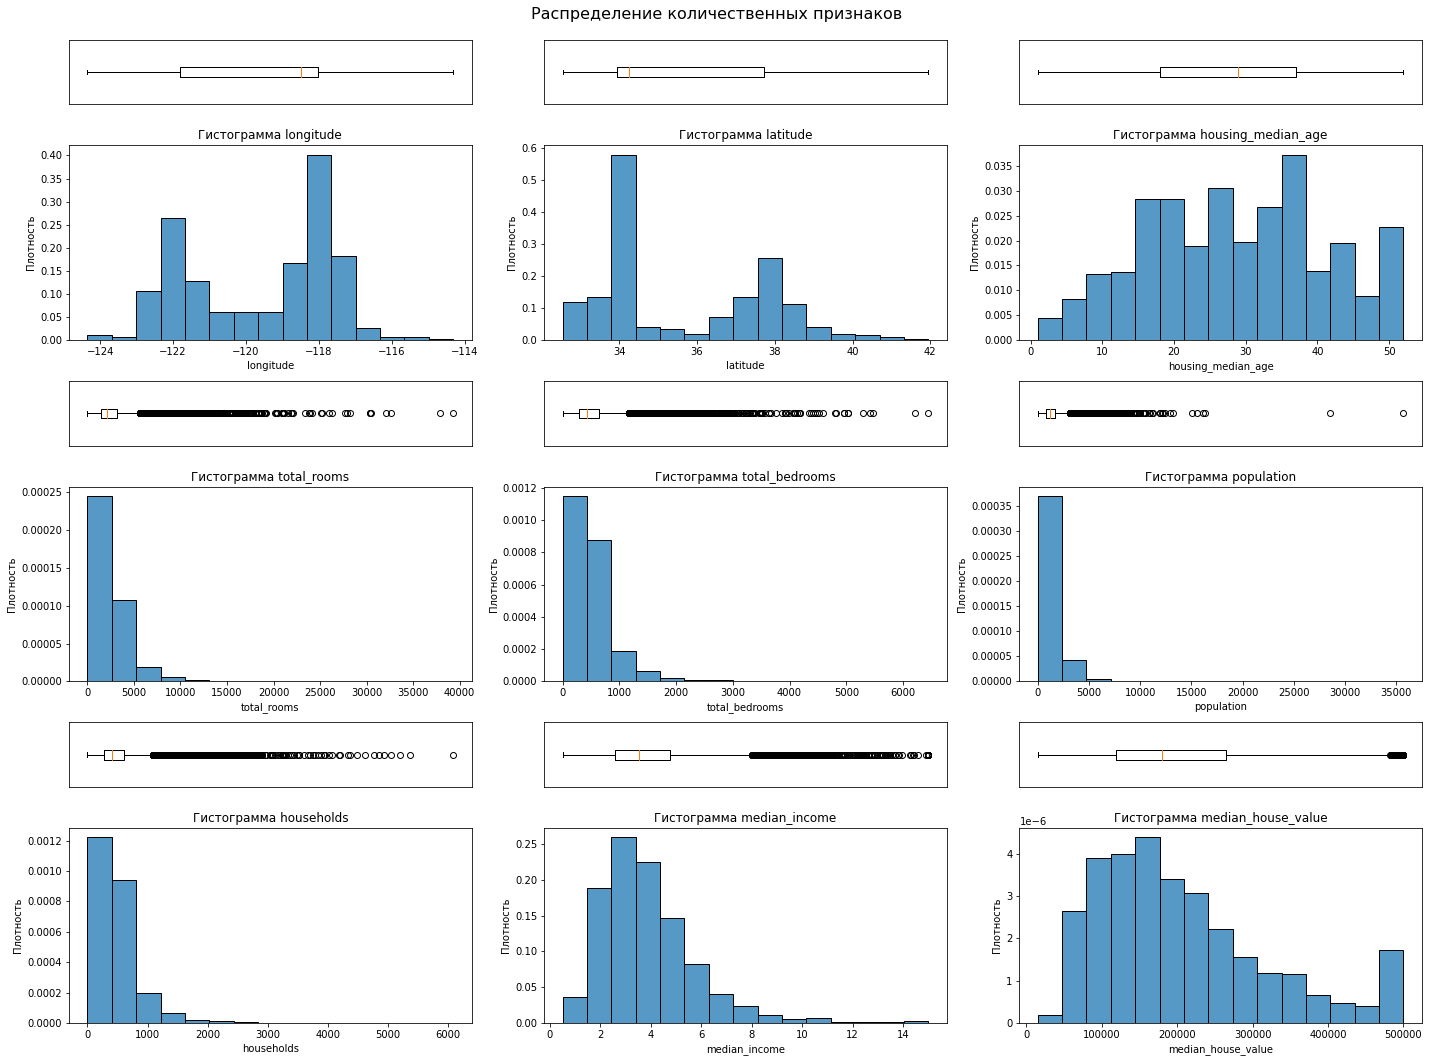

In [15]:
visualizer.plot_quantitative()

Вижу, что в `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`, `median_house_value` присутствуют выбросы. Они находятся за пределом верхнего порога, удалю их.

In [16]:
class OutlierHandler:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.total_rows = num_rows
        
    def count_outliers(self, columns, multiplier=2.5):
        outliers_counts = {}
        
        for col_name in columns:

            q3 = self.dataframe.approxQuantile(col_name, [0.75], 0.05)[0]
            upper_bound = q3 + multiplier * (q3 - self.dataframe.approxQuantile(col_name, [0.25], 0.05)[0])
            
            outliers_count = self.dataframe.filter(col(col_name) > upper_bound).count()
            outliers_counts[col_name] = outliers_count
            
            outliers_percentage = (outliers_count / self.total_rows) * 100
            print(f"Количество выбросов в столбце '{col_name}': {outliers_count}, Процент выбросов: {outliers_percentage:.2f}%")
        
        return outliers_counts
    
    def remove_outliers(self, columns, multiplier=2.5):
        filtered_df = self.dataframe
        
        for col_name in columns:

            q3 = filtered_df.approxQuantile(col_name, [0.75], 0.05)[0]
            upper_bound = q3 + multiplier * (q3 - filtered_df.approxQuantile(col_name, [0.25], 0.05)[0])
            filtered_df = filtered_df.filter(col(col_name) <= upper_bound)
        
        return filtered_df

In [17]:
handler = OutlierHandler(df)

outliers_counts = handler.count_outliers(['total_rooms', 'total_bedrooms', 
                                          'population', 'households', 'median_income', 'median_house_value'])
print("\n")

Количество выбросов в столбце 'total_rooms': 856, Процент выбросов: 4.15%
Количество выбросов в столбце 'total_bedrooms': 823, Процент выбросов: 3.99%
Количество выбросов в столбце 'population': 765, Процент выбросов: 3.71%
Количество выбросов в столбце 'households': 777, Процент выбросов: 3.76%
Количество выбросов в столбце 'median_income': 354, Процент выбросов: 1.72%
Количество выбросов в столбце 'median_house_value': 0, Процент выбросов: 0.00%




В среднем, количестесво выбросов составляют около 5% и не превышают более 10%. Здесь лучше использовать менее строгий критерий для оценивания выбросов, тк под удаление может уйти более 10% от общего числа строк.

In [18]:
df = handler.remove_outliers(['total_rooms', 'total_bedrooms',
                              'population', 'households', 'median_income', 'median_house_value'])

Теперь посмотрю, как коррелируют между собой признаки.

24/07/04 09:20:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/07/04 09:20:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


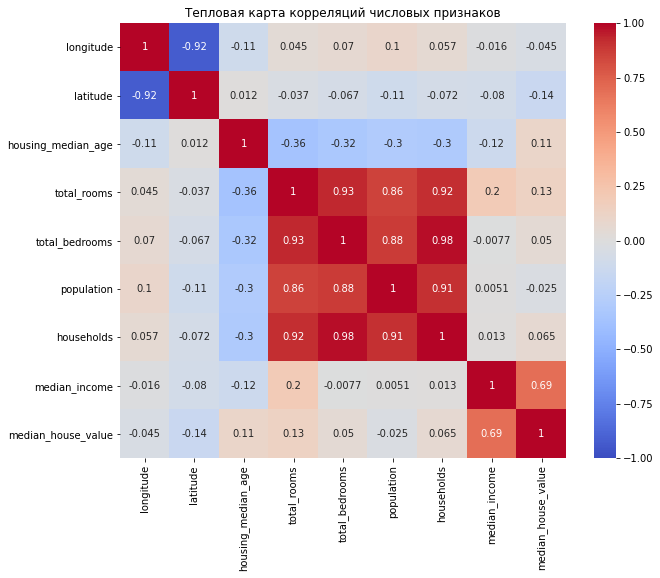

In [19]:
visualizer.plot_correlation_heatmap()

- Вижу, что `total_rooms`, `total_bedrooms`, `population`, `households` имеют силную корреляцию между собой, то есть присутствует мультикоррелиарность. Также присутствует связб между `longitude` и `latitude`. Имеет смысл на этапе обучения модели  использовать регуляризацию.
- Есть связь между таргетом и `median_income`.

## Выводы

На данном этапе сделала следующие шаги:
1. Ознакомилась с данными. В столбце `total_bedrooms` были пропуски, мною было принято решение удалить их. Дубликаты отсутствовали. 
2. В колонках `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`, `median_house_value` были выбросы d верхней границе. По итогу количество строк составляет `18624`.
3. Признаки `total_rooms`, `total_bedrooms`, `population`, `households` имеют сильную корреляцию между собой на этапе обучения модели использую регуляризацию, чтобы уменьшить влияение мультикоррелиарности. 

# Обучение моделей <a id='2'></a>

Для того, чтобы обучить модель и следует трансформировать количественные и категориальные признаки. Далее буду обучать модель, для ее оценки использую метрики `RMSE`, `MAE` и `R2`. Также по условию нужно сравнить по условию метрики для двух наборов данных: со всеми признаками и только количественные. Ниже класс, который выполняет все казанные шаги. 
Еще дополнила класс функицией подборки гипперпараметров с использованием кросс-валидации.

Класс содержит:
- `__init__`: Инициализация класса с DataFrame, категориальными, количественными признаками, таргетом.
- `preprocess_data`: Предобработка данных (индексация, One-Hot-Encoding, стандартизация, векторизация и объединение признаков).
- `preprocess_numerical_only`: Предобработка данных, только количетсвенные признаки.
- `train_linear_regression`: Обучение модели линейной регрессии с использованием регуляризации и расчетом RMSE на тестовой выборке.
- `tune_hyperparameters`: Подбор наилучших параметров с использованием кросс-валидации для гиперпараметров regParam, elasticNetParam и maxIter.

In [20]:
class DataPreprocessor:
    def __init__(self, dataframe, categorical_cols, numerical_cols, label_col):
        self.dataframe = dataframe
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols
        self.label_col = label_col
        self.pipeline_model = None
        self.transformed_df = None

    def preprocess_data(self):
        
        indexers = [StringIndexer(inputCol=c, outputCol=c+'_idx') for c in self.categorical_cols]
        encoders = [OneHotEncoder(inputCol=c+'_idx', outputCol=c+'_ohe') for c in self.categorical_cols]
        categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in self.categorical_cols], 
                                                outputCol='categorical_features')
        
        numerical_assembler = VectorAssembler(inputCols=self.numerical_cols, outputCol='numerical_features')
        standardScaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')
        
        final_assembler = VectorAssembler(inputCols=['categorical_features', 'numerical_features_scaled'], 
                                          outputCol='features')
        pipeline = Pipeline(stages=indexers + encoders + [categorical_assembler, 
                                                          numerical_assembler, 
                                                          standardScaler, 
                                                          final_assembler])
        self.pipeline_model = pipeline.fit(self.dataframe)
        self.transformed_df = self.pipeline_model.transform(self.dataframe)
        
        return self.transformed_df

    def preprocess_numerical_only(self):
        
        numerical_assembler = VectorAssembler(inputCols=self.numerical_cols, outputCol='numerical_features')
        standardScaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')
        
        final_assembler = VectorAssembler(inputCols=['numerical_features_scaled'], outputCol='features')
        pipeline = Pipeline(stages=[numerical_assembler, standardScaler, final_assembler])
        self.pipeline_model = pipeline.fit(self.dataframe)
        self.transformed_df = self.pipeline_model.transform(self.dataframe)
        
        return self.transformed_df

    def train_linear_regression(self, regParam=0.1, elasticNetParam=0.0, maxIter=100):
        
        train_df, test_df = self.transformed_df.randomSplit([0.8, 0.2], seed=42)
        
        lr = LinearRegression(featuresCol='features', labelCol=self.label_col, regParam=regParam, 
                              elasticNetParam=elasticNetParam, maxIter=maxIter)
        lr_model = lr.fit(train_df)
        
        predictions = lr_model.transform(test_df)
        evaluator_rmse = RegressionEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="rmse")
        evaluator_mae = RegressionEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="mae")
        evaluator_r2 = RegressionEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="r2")
        rmse = evaluator_rmse.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R2: {r2}")
        
        return lr_model, rmse, mae, r2

    def tune_hyperparameters(self):
        
        train_df, test_df = self.transformed_df.randomSplit([0.8, 0.2], seed=42)
        
        lr = LinearRegression(featuresCol='features', labelCol=self.label_col)
        
        param_grid = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0]) \
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
            .addGrid(lr.maxIter, [50, 100, 150]) \
            .build()
        evaluator = RegressionEvaluator(labelCol=self.label_col, predictionCol="prediction", metricName="rmse")
        crossval = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
        cv_model = crossval.fit(train_df)
        
        best_model = cv_model.bestModel
        
        predictions = best_model.transform(test_df)
        rmse = evaluator.evaluate(predictions)
        best_reg_param = best_model._java_obj.getRegParam()
        best_elastic_net_param = best_model._java_obj.getElasticNetParam()
        best_max_iter = best_model._java_obj.getMaxIter()
        print(f"Best RegParam: {best_reg_param}")
        print(f"Best ElasticNetParam: {best_elastic_net_param}")
        print(f"Best MaxIter: {best_max_iter}")
        print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
        
        return best_model, best_reg_param, best_elastic_net_param, best_max_iter, rmse

Теперь запишу названия категориальных и количественных колонок.

In [21]:
categorical_cols = ['ocean_proximity']
numerical_cols  = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population",
                   "households", "median_income"]
target = "median_house_value"

Для всех признаков получим следующий результат:

In [22]:
preprocessor = DataPreprocessor(df, categorical_cols=categorical_cols, 
                                numerical_cols=numerical_cols, 
                                label_col=target)

transformed_df = preprocessor.preprocess_data()
lr_model, rmse, mae, r2 = preprocessor.train_linear_regression(regParam=0.1, elasticNetParam=0.0, maxIter=100)

24/07/04 09:20:31 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/07/04 09:20:31 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


RMSE: 62933.71309744741
MAE: 46641.79044501536
R2: 0.6672883146757128


Для линейной модели с гипперпарметрами `regParam` 0.1, `elasticNetParam` 0.0, `maxIter` 100

Получила следующие результаты:
- Модель имеет среднюю ошибку предсказания (`MAE`) примерно 46642.
- Среднеквадратичная ошибка (`RMSE`) составляет 62933, что может указывать на существенную дисперсию в предсказаниях модели.
- Коэффициент детерминации (`R2`) на уровне 0.667 показывает, что модель объясняет значительную часть изменчивости зависимой переменной, но есть еще место для улучшений.

In [23]:
best_model, best_reg_param, best_elastic_net_param, best_max_iter, rmse = preprocessor.tune_hyperparameters()

Best RegParam: 0.5
Best ElasticNetParam: 0.0
Best MaxIter: 50
Root Mean Squared Error (RMSE) on test data = 62933.3359233547


Лучшими парматерами для линейной модели оказались:
- `RegParam`: 1.0
- `ElasticNetParam`: 0.0
- `MaxIter`: 50

In [24]:
numerical_df = preprocessor.preprocess_numerical_only()
numerical_lr_model, numerical_rmse, numerical_mae, numerical_r2 = preprocessor.train_linear_regression(regParam=0.1, 
                                                                                                       elasticNetParam=0.0, 
                                                                                                       maxIter=100)

RMSE: 63495.82837131296
MAE: 47388.020092307976
R2: 0.6613183014762671


Если только присутствуют количественные признаки:
- Модель, использующая только числовые признаки, имеет схожие результаты с моделью, использующей все признаки, но с некоторым ухудшением.
- Среднеквадратичная ошибка (`RMSE`) составляет примерно 63495, что может указывать на существенную дисперсию в предсказаниях модели.
- Средняя абсолютная ошибка (`MAE`) составляет примерно 47388, что является средним значением ошибки предсказания.

Теперь посмотрю как изменятся метрики с новыми гипперпараметрами для разных наборов данных.

In [25]:
transformed_df = preprocessor.preprocess_data()
lr_model, rmse, mae, r2 = preprocessor.train_linear_regression(regParam=1.0, elasticNetParam=0.0, maxIter=50)

RMSE: 62932.88646155222
MAE: 46641.06278761675
R2: 0.6672970549709228


In [26]:
numerical_df = preprocessor.preprocess_numerical_only()
numerical_lr_model, numerical_rmse, numerical_mae, numerical_r2 = preprocessor.train_linear_regression(regParam=0.5, 
                                                                                                       elasticNetParam=0.5, 
                                                                                                       maxIter=50)

RMSE: 63500.11315964848
MAE: 47383.38124817049
R2: 0.6612725904935984


Результат не сильно отличается от дефолтных гипперпарметров.

In [27]:
spark.stop()

## Вывод

На данном этапе была обучена модель `LinearRegression`. Сравнивала результаты модели (до и после кросс-валидаци)и, обученной на всех признаках и только на числовых признаках, по метрикам `RMSE`, `MAE` и `R2`.

# Анализ результатов <a id='3'></a>

Лучший результат:

- `RMSE`: 62932.88646155222
- `MAE`: 46641.06278761675
- `R2`: 0.6672970549709228

Исходя из результатов, можно сделать вывод, что после кросс-валидации и подбора гиперпараметров модель линейной регрессии на всех доступных признаках продолжает показывать лучшие результаты по метрикам качества (`RMSE`, `MAE`, `R2`) по сравнению с моделью, использующей только количественные признаки. Это свидетельствует о том, что включение категориальных признаков помогает улучшить качество прогнозирования.